# CAP 6618 - Machine Learning for Computer Vision

# Project 2 Digit Classification Using Neural Networks
Design and implement a complete solution to the problem of handwritten digit recognition, stated as follows: “given an image of a handwritten digit, produce the corresponding numerical value.” Essentially, you will build, fine-tune, and evaluate a 10-class (multi-layer perceptron) neural network-based classifier which will employ the pixel values of the images as features. ONLY Neural Networks (Deep Learning next project)

### Educational Objectives
* Learn how to implement a neural network-based classifier in Python
* Learn how to evaluate and fine-tune the performance of the neural network-based classifier
* Learn how to test the neural network-based classifier and produce a set of plots, performance measures, and results that can be compared against other groups / classmates

### Dataset
Make sure to download the 'mnist.pkl.gz' file from https://github.com/MichalDanielDobrzanski/DeepLearningPython35 (Place the dataset file in this jupyter notebook directory)

# Step 1: Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# Standard library
import random
import pickle
import gzip
import warnings

# Sklearn warning
from sklearn.exceptions import ConvergenceWarning

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Shared Methods

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    """ Method to save figures to your local computer"""
    image_dir = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

    path = os.path.join(image_dir, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def plot_confusion_matrix(matrix):
    """ Method to plot confusion matrix"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [4]:
def plot_digits(instances, images_per_row=10, **options):
    """ Method to plot sample digits"""
    size = 28
    
    # If there are instances, plot them
    if(len(instances)):
        images_per_row = min(len(instances), images_per_row)
        images = [instance.reshape(size,size) for instance in instances]
        n_rows = (len(instances) - 1) // images_per_row + 1
        row_images = []
        n_empty = n_rows * images_per_row - len(instances)
        images.append(np.zeros((size, size * n_empty)))
        for row in range(n_rows):
            rimages = images[row * images_per_row : (row + 1) * images_per_row]
            row_images.append(np.concatenate(rimages, axis=1))
        image = np.concatenate(row_images, axis=0)
        plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    # Else, plot an empty plot
    else:
        empty_array = np.zeros((5, 5))
        plt.imshow(empty_array, cmap = matplotlib.cm.binary, **options)
    
    plt.axis("off")

In [5]:
# Adapted From https://github.com/MichalDanielDobrzanski/DeepLearningPython35

"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation. It is not optimized, and omits many desirable features.
"""

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    
    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
            
        learning_curve = list()
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                eval_result = self.evaluate(test_data)
                eval_accuracy = eval_result/n_test
                learning_curve.append(eval_accuracy)
                
                print("Epoch {} : {} / {}".format(j,eval_result,n_test))
            else:
                print("Epoch {} complete".format(j))
                
        return learning_curve
        

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [6]:
# Source: https://github.com/MichalDanielDobrzanski/DeepLearningPython35

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)
    #return (list(training_data), list(validation_data), list(test_data))

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# Step 2: Load (and split) the MNIST dataset

In [7]:
# Load the dataset
training_data, validation_data, test_data = load_data_wrapper()
training_data, validation_data, test_data = list(training_data), list(validation_data), list(test_data)

In [8]:
np.shape(training_data)

(50000, 2)

In [9]:
np.shape(validation_data)

(10000, 2)

In [10]:
np.shape(test_data)

(10000, 2)

Saving figure digit_sample_plot


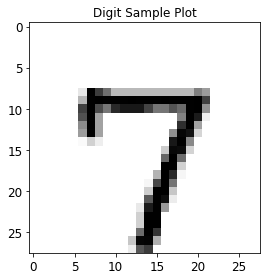

In [11]:
# Plot a random digit sample
some_digit_index = 37500
some_digit = training_data[some_digit_index][0]     # [0] Digit data, [1] Digit label
some_digit_image = np.reshape(some_digit,(28, 28))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

plt.title("Digit Sample Plot")
#plt.axis("off")

save_fig("digit_sample_plot")
plt.show()

In [12]:
training_data[some_digit_index][1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [13]:
# Print the sample digit's label
print('The ground truth label for the sample digit above is: ', np.argmax(training_data[some_digit_index][1], axis=0)[0])

The ground truth label for the sample digit above is:  7


### Shared Configuration of Neural Networks

In [14]:
epochs = 30
mini_batch_size = 10
eta = 3.0

# Step 3: Set up the First Network with Three Layers 

Input layer: 784 neurons<br>
Hidden layer: 30 neurons<br>
Output layer: 10 neurons

In [15]:
# Create a neural network
net1 = Network([784, 30, 10])

# Step 4: Train the network using SGD  

30 epochs, mini-batch size = 10, and eta = 3.0

In [16]:
# Configure and train the neural network
net1_learning_curve = net1.SGD(training_data, epochs, mini_batch_size, eta, test_data=test_data)

Epoch 0 : 9078 / 10000
Epoch 1 : 9225 / 10000
Epoch 2 : 9290 / 10000
Epoch 3 : 9341 / 10000
Epoch 4 : 9372 / 10000
Epoch 5 : 9434 / 10000
Epoch 6 : 9407 / 10000
Epoch 7 : 9442 / 10000
Epoch 8 : 9456 / 10000
Epoch 9 : 9473 / 10000
Epoch 10 : 9464 / 10000
Epoch 11 : 9485 / 10000
Epoch 12 : 9478 / 10000
Epoch 13 : 9481 / 10000
Epoch 14 : 9477 / 10000
Epoch 15 : 9468 / 10000
Epoch 16 : 9473 / 10000
Epoch 17 : 9479 / 10000
Epoch 18 : 9487 / 10000
Epoch 19 : 9505 / 10000
Epoch 20 : 9507 / 10000
Epoch 21 : 9492 / 10000
Epoch 22 : 9491 / 10000
Epoch 23 : 9491 / 10000
Epoch 24 : 9511 / 10000
Epoch 25 : 9530 / 10000
Epoch 26 : 9505 / 10000
Epoch 27 : 9513 / 10000
Epoch 28 : 9511 / 10000
Epoch 29 : 9522 / 10000


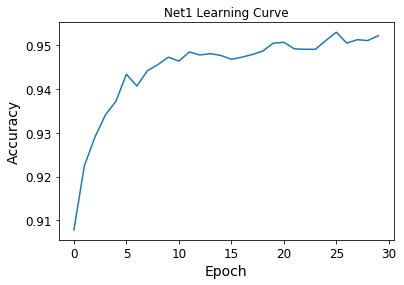

In [17]:
# Plot the Learning Curve for Net1
x_value = np.arange(0, len(net1_learning_curve), 1)
plt.plot(x_value, net1_learning_curve)
plt.title("Net1 Learning Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Step 5: Set up the Second Network with Three Layers 

Input layer: 784 neurons<br>
Hidden layer: 100 neurons<br>
Output layer: 10 neurons

In [18]:
# Create a neural network
net2 = Network([784, 100, 10])

# Step 6: Train the network using SGD  

30 epochs, mini-batch size = 10, and eta = 3.0

In [19]:
# Configure and train the neural network
net2_learning_curve = net2.SGD(training_data, epochs, mini_batch_size, eta, test_data=test_data)

Epoch 0 : 8194 / 10000
Epoch 1 : 8384 / 10000
Epoch 2 : 8426 / 10000
Epoch 3 : 8472 / 10000
Epoch 4 : 8538 / 10000
Epoch 5 : 8550 / 10000
Epoch 6 : 8586 / 10000
Epoch 7 : 8598 / 10000
Epoch 8 : 8594 / 10000
Epoch 9 : 8610 / 10000
Epoch 10 : 8617 / 10000
Epoch 11 : 8638 / 10000
Epoch 12 : 8641 / 10000
Epoch 13 : 8635 / 10000
Epoch 14 : 8650 / 10000
Epoch 15 : 8650 / 10000
Epoch 16 : 8662 / 10000
Epoch 17 : 8675 / 10000
Epoch 18 : 8651 / 10000
Epoch 19 : 8678 / 10000
Epoch 20 : 8659 / 10000
Epoch 21 : 8684 / 10000
Epoch 22 : 8663 / 10000
Epoch 23 : 8683 / 10000
Epoch 24 : 8716 / 10000
Epoch 25 : 9602 / 10000
Epoch 26 : 9596 / 10000
Epoch 27 : 9602 / 10000
Epoch 28 : 9620 / 10000
Epoch 29 : 9613 / 10000


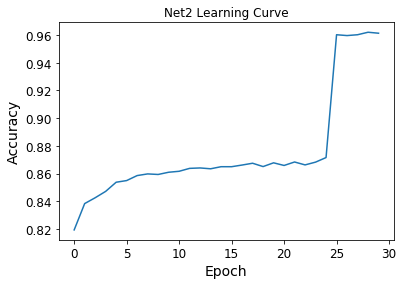

In [20]:
# Plot the Learning Curve for Net2
x_value = np.arange(0, len(net2_learning_curve), 1)
plt.plot(x_value, net2_learning_curve)
plt.title("Net2 Learning Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Step 7: Set up Third network with Only Two Layers 

Input layer: 784 neurons<br>
Output layer: 10 neurons

In [21]:
## Create a neural network
net3 = Network([784, 10])

# Step 8: Train the network using SGD  

30 epochs, mini-batch size = 10, and eta = 3.0

In [22]:
# Configure and train the neural network
net3_learning_curve = net3.SGD(training_data, epochs, mini_batch_size, eta, test_data=test_data)

Epoch 0 : 4038 / 10000
Epoch 1 : 4812 / 10000
Epoch 2 : 4875 / 10000
Epoch 3 : 4892 / 10000
Epoch 4 : 4864 / 10000
Epoch 5 : 4945 / 10000
Epoch 6 : 5828 / 10000
Epoch 7 : 6096 / 10000
Epoch 8 : 7231 / 10000
Epoch 9 : 7326 / 10000
Epoch 10 : 7334 / 10000
Epoch 11 : 7327 / 10000
Epoch 12 : 7350 / 10000
Epoch 13 : 7345 / 10000
Epoch 14 : 7358 / 10000
Epoch 15 : 7370 / 10000
Epoch 16 : 7383 / 10000
Epoch 17 : 7383 / 10000
Epoch 18 : 7354 / 10000
Epoch 19 : 7388 / 10000
Epoch 20 : 7392 / 10000
Epoch 21 : 7407 / 10000
Epoch 22 : 7399 / 10000
Epoch 23 : 7407 / 10000
Epoch 24 : 7426 / 10000
Epoch 25 : 7433 / 10000
Epoch 26 : 7433 / 10000
Epoch 27 : 7434 / 10000
Epoch 28 : 7431 / 10000
Epoch 29 : 7448 / 10000


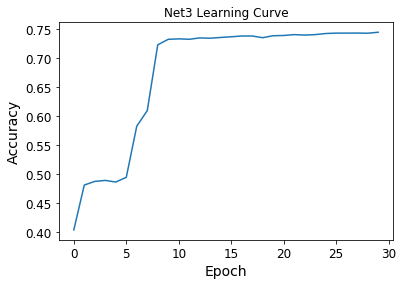

In [23]:
# Plot the Learning Curve for Net2
x_value = np.arange(0, len(net3_learning_curve), 1)
plt.plot(x_value, net3_learning_curve)
plt.title("Net3 Learning Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Step 9: Classification using MLP Classifier from scikit-learn

In [24]:
# Load the same data but with the load_data() method instead of the load_data_wrapper()
training_data, validation_data, test_data = load_data()
X_train, y_train = training_data
X_test, y_test = test_data

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
from sklearn.neural_network import MLPClassifier

MLP_clf = MLPClassifier(activation = 'logistic', solver ='sgd', batch_size='auto', 
                         max_iter = epochs, hidden_layer_sizes=(30,), learning_rate_init = eta)
MLP_clf

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30,), learning_rate='constant',
       learning_rate_init=3.0, max_iter=30, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [26]:
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html
# Catch warning and ignore the ConvergenceWarning

# Train the classifier
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    MLP_clf.fit(X_train,y_train)

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score

# Evaluate a score by cross-validation
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    MLP_cross_val_score = cross_val_score(MLP_clf, X_train, y_train, cv=3, scoring="accuracy")

MLP_cross_val_score

array([0.89627452, 0.9350213 , 0.93602976])

In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Generate cross-validated estimates for each input data point then compute the confusion matrix 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    y_train_pred = cross_val_predict(MLP_clf, X_train, y_train, cv=3)   
    
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[4639,    1,   88,   87,   20,   21,   22,   21,   25,    8],
       [  11, 5364,   22,  105,   10,   24,    6,   45,   79,   12],
       [1175,   56, 2863,  259,   71,   30,  219,  142,  132,   21],
       [  97,   46,  131, 4470,   10,  120,   10,   84,   99,   34],
       [  45,   32,   26,    8, 3765,    2,   65,   83,   12,  821],
       [ 162,   65,   53, 1431,   45, 2493,   71,   44,  101,   41],
       [ 165,   59,   36,   18,   62,   51, 4505,    7,   45,    3],
       [  27,   26,   24,   64,   55,   10,    0, 4784,   17,  168],
       [  73,  185,   53, 1424,   30,  107,   52,   49, 2753,  116],
       [  34,   27,    6,   94,  219,   29,    8,  294,   24, 4253]],
      dtype=int64)

Saving figure confusion_matrix_MLPClassifier


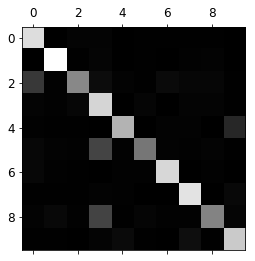

In [29]:
# Plot the result confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_MLPClassifier", tight_layout=False)
plt.show()

Saving figure confusion_matrix_errors_MLPClassifier


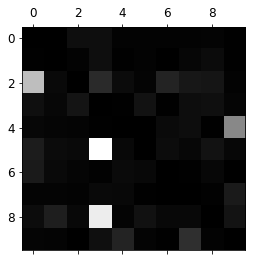

In [30]:
# Plot the confusion matrix errors (the lighter the block, the more errors)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_MLPClassifier", tight_layout=False)
plt.show()

In [31]:
# Evaluate accuracy on test set
y_pred = MLP_clf.predict(X_test)
MLPClassifier_score = MLP_clf.score(X_test,y_test)
print("Accuracy score for the MLP Classifier is", MLPClassifier_score)

Accuracy score for the MLP Classifier is 0.826


### Data Normalization / Standardization

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

# Same network configurations as the previous section
standardized_MLPClassifier = MLPClassifier(activation = 'logistic', solver ='sgd', batch_size='auto', 
                                           max_iter = epochs, hidden_layer_sizes=(30,), learning_rate_init = eta)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    standardized_MLPClassifier.fit(X_train_scaled, y_train)

In [33]:
# Evaluate a score by cross-validation
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    standardized_MLP_cv_score = cross_val_score(standardized_MLPClassifier, X_train_scaled, y_train, cv=3, scoring="accuracy")
    
standardized_MLP_cv_score

array([0.92057112, 0.92116158, 0.91484638])

In [34]:
# Generate cross-validated estimates for each input data point then compute the confusion matrix 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    y_train_pred = cross_val_predict(standardized_MLPClassifier, X_train_scaled, y_train, cv=3) 
    
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[4755,    2,   27,   15,    5,   40,   36,    7,   32,   13],
       [   1, 5491,   38,   27,    5,   11,   15,   16,   67,    7],
       [  39,   42, 4561,   68,   29,   23,   66,   49,   76,   15],
       [  23,   32,  158, 4498,    5,  156,    8,   65,  124,   32],
       [   9,   13,   45,    9, 4468,   11,   46,   39,   25,  194],
       [  52,   23,   32,  157,   29, 3985,   70,   12,   99,   47],
       [  59,   18,   58,    4,   35,   55, 4674,    4,   41,    3],
       [  20,   28,   72,   26,   49,   14,    4, 4817,   21,  124],
       [  38,   79,   94,  111,   36,  128,   42,   30, 4212,   72],
       [  32,    8,   15,   58,  177,   42,    3,  260,   63, 4330]],
      dtype=int64)

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score

# Evaluate accuracy on test set for the normalized/standardized
y_pred_scaled = standardized_MLPClassifier.predict(X_test_scaled)
MLPClassifier_STANDARDIZED_score = accuracy_score(y_test, y_pred_scaled)
print("Accuracy score for the MLP Classifier with data normalization/standardization", MLPClassifier_STANDARDIZED_score) 

Accuracy score for the MLP Classifier with data normalization/standardization 0.9339


### Hyperparameters Optimization 

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

# Chosen parameters for optimization
parameters = {'hidden_layer_sizes': [(30,),(100,)],
              'activation': ['logistic', 'relu'], 
              'learning_rate': ['constant', 'adaptive'],
              'alpha': [0.0001, 0.05]}

In [37]:
            ###  Exhaustive Grid Search ###

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

MLPClassifier_GridSearchCV = GridSearchCV(MLP_clf, parameters, scoring='accuracy', cv=3)
MLPClassifier_GridSearchCV

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30,), learning_rate='constant',
       learning_rate_init=3.0, max_iter=30, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(30,), (100,)], 'activation': ['logistic', 'relu'], 'learning_rate': ['constant', 'adaptive'], 'alpha': [0.0001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
# Train the Classifier
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    MLPClassifier_GridSearchCV.fit(X_train, y_train)

In [39]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

print("Best parameters set found on development set:", MLPClassifier_GridSearchCV.best_params_)

print("\nGrid scores on development set:")
means = MLPClassifier_GridSearchCV.cv_results_['mean_test_score']
stds = MLPClassifier_GridSearchCV.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, MLPClassifier_GridSearchCV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set: {'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

Grid scores on development set:
0.905 (+/-0.053) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (30,), 'learning_rate': 'constant'}
0.919 (+/-0.027) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive'}
0.516 (+/-0.641) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.379 (+/-0.672) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
0.938 (+/-0.008) for {'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes': (30,), 'learning_rate': 'constant'}
0.926 (+/-0.016) for {'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive'}
0.946 (+/-0.009) for {'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes':

### MLP Classifier with Normalization/Standardization and Hyperparameters Optimization

In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.pipeline import Pipeline

MLPClassifier_BEST_pipe = Pipeline([('scaler', StandardScaler()),
                                   ('mlpc', MLPClassifier(**MLPClassifier_GridSearchCV.best_params_))])

# Train the classifier
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
    MLPClassifier_BEST_pipe.fit(X_train, y_train)

# Note: 'MLPClassifier_GridSearchCV.best_params_' come from Hyperparameters Optimization section
#        StandardScaler is in the Pipeline already 

In [41]:
# Get the score for the classifier
MLPClassifier_BEST_score = MLPClassifier_BEST_pipe.score(X_test, y_test)
print("Accuracy score for the MLP Classifier with normalization/standardization")
print("and hyperparameters otimization:\t", MLPClassifier_BEST_score)

Accuracy score for the MLP Classifier with normalization/standardization
and hyperparameters otimization:	 0.974


### Classifiers Results

In [42]:
# Results of different classifiers
print("MLP Classifier accuracy score: ", MLPClassifier_score)
print("MLP Classifier with data normalization/standardization accuracy score:", MLPClassifier_STANDARDIZED_score) 
print("MLP Classifier with normalization/standardization and hyperparameters ")
print("optimization accuracy score:" , MLPClassifier_BEST_score)

MLP Classifier accuracy score:  0.826
MLP Classifier with data normalization/standardization accuracy score: 0.9339
MLP Classifier with normalization/standardization and hyperparameters 
optimization accuracy score: 0.974
